### Trying again feature extraction with data augmentation

### This notebook also contains fine tuning

We need an accuracy of 96%

Lets try dropout:  Result: Failed

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Listing 5.16 - Instantiating the VGG16 convolutional base
import tensorflow
from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights = 'imagenet', include_top=False, input_shape=(150,150,3))

# weights: specifies the weight checkpoint from which to initialize the model
# time taken = 5s

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [0]:
# Listing 5.20 Adding a densely connected classifier on top of the convolutional base

from tensorflow.keras import layers, models, optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))     #not using dropout after this layer
#model.add(layers.Dropout(0.5))              # added by myself
model.add(layers.Dense(1, activation = 'sigmoid'))  

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [0]:
conv_base.trainable

True

In [0]:
# conv_base.trainable = False, and  No. of weight tensors
print('This is the number of trainable weights '
'before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False                                  #
print('This is the number of trainable weights '
'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [0]:
# Copied from one of the previous cells:
import os
base_dir = 'drive/My Drive/Colab Notebooks/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [0]:
# Listing 5.21 - Training the model end to end with a frozen convolutional base
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,     # changes after trying dropout
    class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,    # changes after trying dropout
    class_mode='binary')

model.compile(loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc'])

history = model.fit(train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 1887s 19s/step - loss: 0.5884 - acc: 0.7015 - val_loss: 0.4442 - val_acc: 0.8200
Epoch 2/30
100/100 [==============================] - 30s 297ms/step - loss: 0.4729 - acc: 0.7885 - val_loss: 0.3635 - val_acc: 0.8510
Epoch 3/30
100/100 [==============================] - 30s 296ms/step - loss: 0.4347 - acc: 0.7935 - val_loss: 0.3251 - val_acc: 0.8760
Epoch 4/30
100/100 [==============================] - 30s 296ms/step - loss: 0.4051 - acc: 0.8280 - val_loss: 0.3057 - val_acc: 0.8730
Epoch 5/30
100/100 [==============================] - 30s 296ms/step - loss: 0.3805 - acc: 0.8295 - val_loss: 0.2909 - val_acc: 0.8780
Epoch 6/30
100/100 [==============================] - 30s 299ms/step - loss: 0.3675 - acc: 0.8395 - val_loss: 0.2810 - val_acc: 0.8810
Epoch 7/30
100/100 [==============================] - 30s 296ms/step - loss: 0.3509 - acc: 0.8485 - val_lo

### Comments

In [0]:
# Time taken with dropout only (default batch size of 20):  first: 1430s, other epochs: 23s each
# After trying dropout: I tried dropout with a batch_size of 32 for train and validation data
# time taken of first epoch decreased significantly: now each and every epoch is around 35s

In [0]:
# We will try this on jupyter with default batch size ====> Failed

In [0]:
# Trying on TPU

In [0]:
# NOTE:  xuyungit commented on Jul 18, 2018

'''I guess I find out a reason.
Before 2.1.0, actually before commit c25fa38deb4efc5445f64af3ec17eae0eb660d2f, setting conv_base.trainable = False doesn't freeze all layers in conv_base.
With 2.0.x, when I set all layers of conv_base not to be trainable, the acc_val would be around 0.90,
while with 2.2.0, if conv_base is trainable, the acc_val would be improved to 0.96~0.97.'''


'''@xuyungit ah, so prior to 2.1.0 at least part of the convolutional base was being retrained? 
Good spot! Indeed, if you comment out the line 'conv_base.trainable = False', you can get the 96% accuracy.'''

pass

In [0]:
# NOTE: BEST TIMINGS WHEN BATCH SIZE = 20 AND NO DROPOUT. WE WILL TRY AGAIN WITH TPU > TPU is taking time

In [0]:
# Result did not become better when conv_base trainable and set_trainable was set to False

In [0]:
# rough
for layer in conv_base.layers:
  print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [0]:
conv_base.trainable

False

In [0]:
for layer in conv_base.layers:
  layer.trainable = False       # You set this True or False, the status of conv_base.trainable will not be changed.

conv_base.trainable

False

In [0]:
# Listing 5.22 - Freezing all layers up to a specific one by block
# set_trainable is just a variable, nothing else

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

len(model.trainable_weights)    # It must be = 4 + (3*2) = 10

10

In [0]:
model.compile(loss='binary_crossentropy',
optimizer=optimizers.RMSprop(lr=1e-5),
metrics=['acc'])

history = model.fit(
train_generator,
steps_per_epoch=100,
epochs=30,
validation_data=validation_generator,
validation_steps=50)

Epoch 1/30
100/100 [==============================] - 31s 309ms/step - loss: 0.3000 - acc: 0.8635 - val_loss: 0.2221 - val_acc: 0.9050
Epoch 2/30
100/100 [==============================] - 31s 306ms/step - loss: 0.2791 - acc: 0.8790 - val_loss: 0.2085 - val_acc: 0.9150
Epoch 3/30
100/100 [==============================] - 31s 306ms/step - loss: 0.2374 - acc: 0.8935 - val_loss: 0.2285 - val_acc: 0.9120
Epoch 4/30
100/100 [==============================] - 31s 305ms/step - loss: 0.2118 - acc: 0.9105 - val_loss: 0.1948 - val_acc: 0.9240
Epoch 5/30
100/100 [==============================] - 31s 306ms/step - loss: 0.1977 - acc: 0.9205 - val_loss: 0.1987 - val_acc: 0.9240
Epoch 6/30
100/100 [==============================] - 31s 305ms/step - loss: 0.1882 - acc: 0.9265 - val_loss: 0.2016 - val_acc: 0.9190
Epoch 7/30
100/100 [==============================] - 31s 306ms/step - loss: 0.1860 - acc: 0.9250 - val_loss: 0.1885 - val_acc: 0.9300
Epoch 8/30
100/100 [==============================] - 3

In [0]:
# Now try 70 more epochs
history = model.fit(
train_generator,
steps_per_epoch=100,
epochs=7 0,
validation_data=validation_generator,
validation_steps=50)

Epoch 1/70
100/100 [==============================] - 30s 305ms/step - loss: 0.0674 - acc: 0.9710 - val_loss: 0.2148 - val_acc: 0.9370
Epoch 2/70
100/100 [==============================] - 30s 304ms/step - loss: 0.0650 - acc: 0.9755 - val_loss: 0.2023 - val_acc: 0.9340
Epoch 3/70
100/100 [==============================] - 31s 308ms/step - loss: 0.0608 - acc: 0.9810 - val_loss: 0.2376 - val_acc: 0.9350
Epoch 4/70
100/100 [==============================] - 31s 307ms/step - loss: 0.0625 - acc: 0.9765 - val_loss: 0.3190 - val_acc: 0.9190
Epoch 5/70
100/100 [==============================] - 31s 306ms/step - loss: 0.0454 - acc: 0.9835 - val_loss: 0.2080 - val_acc: 0.9400
Epoch 6/70
100/100 [==============================] - 31s 307ms/step - loss: 0.0630 - acc: 0.9760 - val_loss: 0.2174 - val_acc: 0.9360
Epoch 7/70
100/100 [==============================] - 31s 306ms/step - loss: 0.0582 - acc: 0.9790 - val_loss: 0.2508 - val_acc: 0.9270
Epoch 8/70
100/100 [==============================] - 3

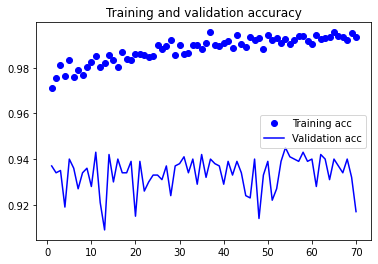

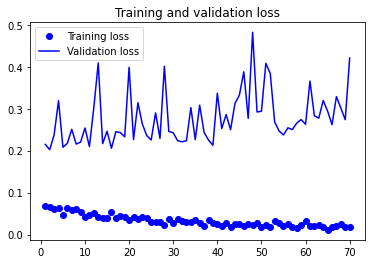

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Validation accuracy is around 92-94%

In [0]:
# Each epoch takes around 31s
# Decide till tomorrow that whole fit would be run (at once) or not. Ans: YES